In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
import sqlite3
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

def process_data(combined_df):
    # y = np.array(yi).reshape(-1, 1)
    y_raw = combined_df.iloc[:, -1].values
    y = np.array(y_raw).reshape(-1, 1)

    attack_types =["Benign", "Backdoor", "Hijacking", "Injection", "DDoS",  "DoS", 
                            "Mirai", "Spoofing", "Recon", "XSS"]

    label_mapping = {}

    # Init
    encode = OneHotEncoder(sparse_output=False)

    # Mã hóa dữ liệu
    y_encoded = encode.fit_transform(y)

    # lấy list label
    labels = encode.categories_[0]

    ## mapping
    for label in labels:
        label_mapping[label]= -1
        for inx, type in enumerate(attack_types):
            if label.find(type)!=-1:
                label_mapping[label] = inx
                break

    # print(label_mapping)

    for i, value in enumerate(combined_df['label']):
        combined_df.at[i, 'label'] = label_mapping.get(value, -1)
        
    # loại bỏ những hàng mà cột label chứa giá trị -1
    combined_df = combined_df[combined_df['label'] != -1]

    # kiểm tra có còn hàng nào chứa -1 k
    # print(combined_df[combined_df['label'] == -1].index)

    # print(combined_df.head())
    # print("------------------------\n")
    
    # sau khi onehotencoder
    # y_final_encoded = encode.fit_transform(combined_df[['label']])

    # # Thêm vào DataFrame
    # encoded_labels = [f'label_{int(i)}' for i in encode.categories_[0]]
    # combined_df_encoded = pd.DataFrame(y_final_encoded, columns=encoded_labels)

    # # Nối với DataFrame gốc (bỏ cột `label` cũ)
    # combined_df = pd.concat([combined_df.reset_index(drop=True), combined_df_encoded], axis=1).drop(columns=['label'])
    
    # print(combined_df['Radius'].head())
    
    return combined_df

In [3]:
attack_types =["Benign", "Backdoor", "Hijacking", "Injection", "DDoS",  "DoS", 
                            "Mirai", "Spoofing", "Recon", "XSS"]
for i, label in enumerate(attack_types):
    print(label + ": " +str(i))

Benign: 0
Backdoor: 1
Hijacking: 2
Injection: 3
DDoS: 4
DoS: 5
Mirai: 6
Spoofing: 7
Recon: 8
XSS: 9


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob

folder_path ="./Dataset"
output_file="Processed_Data/Mapped_Dataset.csv"
# Lấy danh sách tất cả các file CSV trong folder
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

# Đọc tất cả các file CSV vào danh sách DataFrame
# dfs = [pd.read_csv(file) for file in csv_files]
header_saved=False
for file in csv_files:
    print(f"Xử lý {file}")
    
    chunk_size = 1000000    
    for chunk in pd.read_csv(file, chunksize=chunk_size):
        chunk = process_data(chunk)
        # Ghi vào file CSV đích (append mode)
        chunk.to_csv(output_file, mode="a", header=not header_saved, index=False)
        header_saved = True  # Chỉ ghi header lần đầu tiên
        
# # Nếu muốn gộp tất cả các file CSV thành một DataFrame duy nhất
# combined_df = pd.concat(dfs, ignore_index=True)

Xử lý ./Dataset\part-00000-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Xử lý ./Dataset\part-00001-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Xử lý ./Dataset\part-00002-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Xử lý ./Dataset\part-00003-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Xử lý ./Dataset\part-00004-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Xử lý ./Dataset\part-00005-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Xử lý ./Dataset\part-00006-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Xử lý ./Dataset\part-00007-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Xử lý ./Dataset\part-00008-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Xử lý ./Dataset\part-00009-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Xử lý ./Dataset\part-00010-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Xử lý ./Dataset\part-00011-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Xử lý ./Dataset\part-00012-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
Xử lý ./Dataset\part-00013-363d1ba3-8ab5-4f96-bc25-

# Chia dataset cho FL

In [3]:
import dask.dataframe as dd
from dask.distributed import Client
import numpy as np
import pandas as pd
import sys, os

# Khởi tạo Dask client để tối ưu hiệu suất
client = Client()

file_path = "Processed_Data/Mapped_Dataset.csv"
output_files = ["file1.csv", "file2.csv", "file3.csv"]
# Tỉ lệ chia (3:2:1)

# Cấu hình
chunksize = 100000  # Đọc từng phần (tuỳ vào RAM)
temp_dir = "C:/Users/hoang/FileCSV_DACN_2025/"  # Thư mục lưu file tạm

output_files = [temp_dir + output_file for output_file in output_files]
print(output_files)


header_saved=False
for chunk in pd.read_csv(file_path, chunksize=chunksize):
    df_1 = chunk.sample(frac=1/6, random_state=42)
    df_rest = chunk.drop(df_1.index)

    df_2 = df_rest.sample(frac=2/5, random_state=42)
    df_3 = df_rest.drop(df_2.index)

    df_1.to_csv(output_files[0], mode="a", header=not header_saved, index=False)
    df_2.to_csv(output_files[1], mode="a", header=not header_saved, index=False)
    df_3.to_csv(output_files[2], mode="a", header=not header_saved, index=False)
    header_saved = True

c:\Users\hoang\AppData\Local\Programs\Python\Python311\Lib\site-packages\distributed\node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 64779 instead
  warnings.warn(


['C:/Users/hoang/FileCSV_DACN_2025/file1.csv', 'C:/Users/hoang/FileCSV_DACN_2025/file2.csv', 'C:/Users/hoang/FileCSV_DACN_2025/file3.csv']


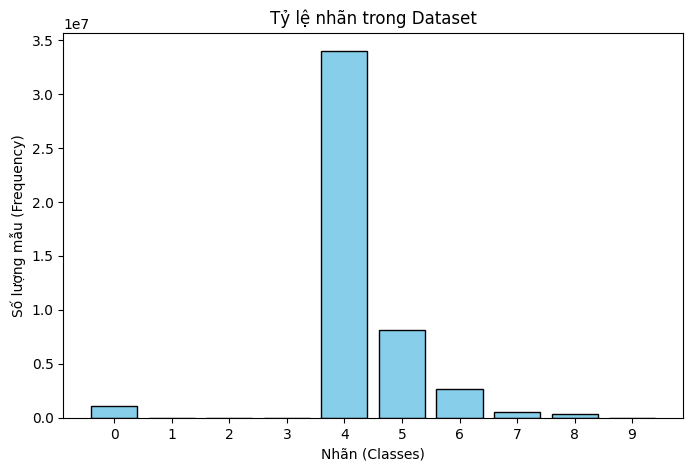

In [1]:
file_path = "Processed_Data/Mapped_Dataset.csv"
import dask.dataframe as dk

import matplotlib.pyplot as plt

df = dk.read_csv(file_path)
# Đếm số lượng mỗi nhãn
label_counts = df['label'].value_counts().compute()

# Vẽ biểu đồ cột
plt.figure(figsize=(8, 5))
plt.bar(label_counts.index, label_counts.values, color='skyblue', edgecolor='black')
plt.xlabel("Nhãn (Classes)")
plt.ylabel("Số lượng mẫu (Frequency)")
plt.title("Tỷ lệ nhãn trong Dataset")
plt.xticks(label_counts.index)
plt.show()

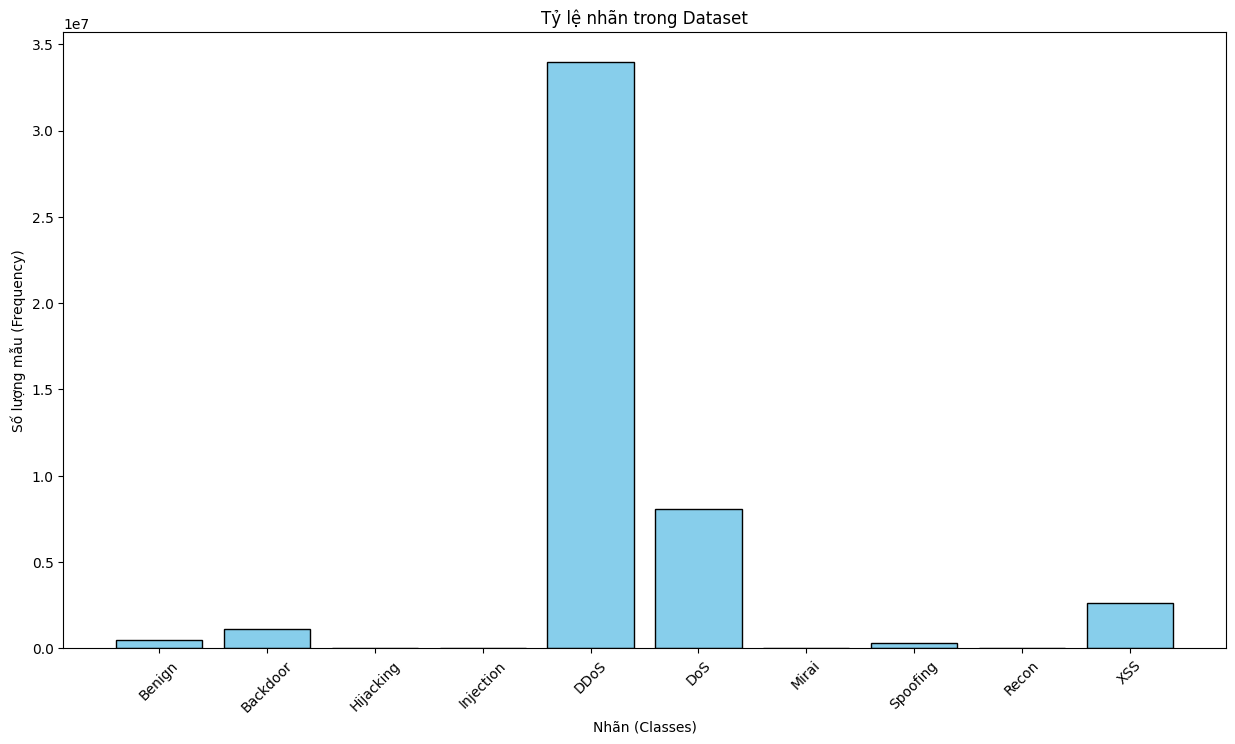

In [3]:
labels = ["Benign", "Backdoor", "Hijacking", "Injection", "DDoS",  "DoS", 
                            "Mirai", "Spoofing", "Recon", "XSS"]
# Vẽ biểu đồ cột
plt.figure(figsize=(15, 8))
plt.bar(labels, label_counts.values, color='skyblue', edgecolor='black')
plt.xlabel("Nhãn (Classes)")
plt.ylabel("Số lượng mẫu (Frequency)")
plt.title("Tỷ lệ nhãn trong Dataset")
plt.xticks(range(len(labels)) ,labels, rotation =45)
plt.show()